# Budowanie, trenowanie i testowanie modelu

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

2025-06-17 12:08:33.058542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 12:08:33.938667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Wczytanie odpowiednich danych

In [2]:
SAVE_DIR = Path("outputs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(str(SAVE_DIR)+'/df_training.csv')
ds = df.to_numpy()

# Wstępne Przetwarzanie Danych

Rozdzielenie danych na wejściowe i wyjściowe

In [4]:
x_ds = ds[:, 0:17] # 17 danych - 3*3xyz + 6*dJ + 2*dG
y_ds = ds[:, 17:]  # 8  danych - 6*pred_dJ + 2*pred_dG
print(x_ds.shape)
print(y_ds.shape)
print(x_ds[0])
print(y_ds[0])

(8060, 17)
(8060, 8)
[ 0.88793552 -0.54713482 -1.7142334   0.24522633  0.16836209 -0.09461975
  0.06873373 -0.36582538 -0.40885925  3.423105    1.230969    1.932432
  1.527801    1.58762     2.663374    0.603365    0.905047  ]
[-0.000294  0.000588  0.000294 -0.000527  0.001726 -0.002205 -0.005113
  0.      ]


Rozdzielenie danych na treningowe i testowe

In [5]:
rand = np.random.permutation(len(x_ds))
x_ds_shuffled = x_ds[rand]
y_ds_shuffled = y_ds[rand]

split_idx = int(len(x_ds_shuffled) * 0.9)
x_train = x_ds_shuffled[:split_idx]
x_test = x_ds_shuffled[split_idx:]
y_train = y_ds_shuffled[:split_idx]
y_test = y_ds_shuffled[split_idx:]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(x_train[0])
print(x_test[0])

(7254, 17)
(806, 17)
(7254, 8)
(806, 8)
[36.38384512 38.72621526 18.06913757 30.7714927  39.24646486 43.88453674
 -0.96134335 35.76788118 28.09803772  3.724839    1.852959    2.001864
  0.834585    1.589825    2.697505    0.184077    1.365241  ]
[-38.93454275  16.45698717 -18.89271545 -50.8499369   17.69328307
 -41.30508423 -31.20726281  24.61950875 -34.35455322   3.583625
   1.903143     1.700541     1.080981     1.571561     3.299689
   0.593138     0.894821  ]


Normalizowanie danych

In [6]:
#"""
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(x_train[0])
print(x_test[0])
#""";

[ 0.36673612  0.86455279  0.72591277  0.29114393  0.81835918  1.43161261
 -0.08165172  0.74254951  1.06198072  1.00981551 -0.02873891  0.94110692
 -2.08023874  0.49625257 -0.1197837  -1.07753784  1.0868266 ]
[-0.55251861  0.41901558 -0.93537219 -0.6464073   0.41883507 -1.53207772
 -0.46549771  0.53649732 -1.40459453  0.53335371  0.14692574  0.07104674
 -0.47948015 -1.00343158  0.91538487  0.56997276 -0.65249129]


Sprawdzenie histogramów danych

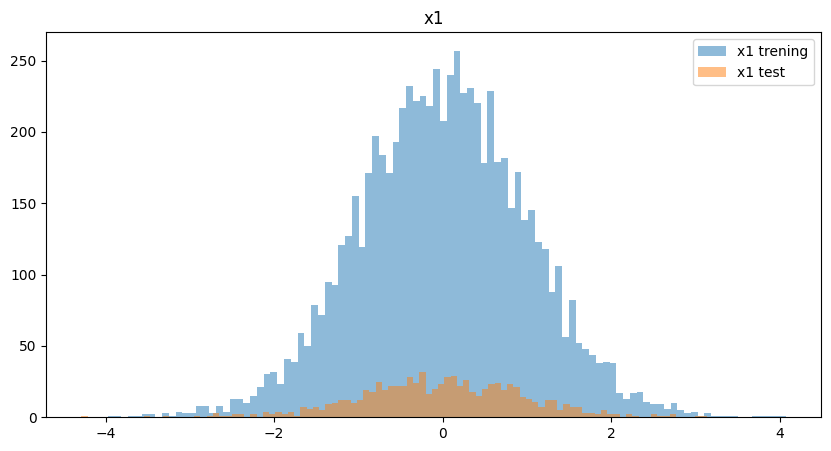

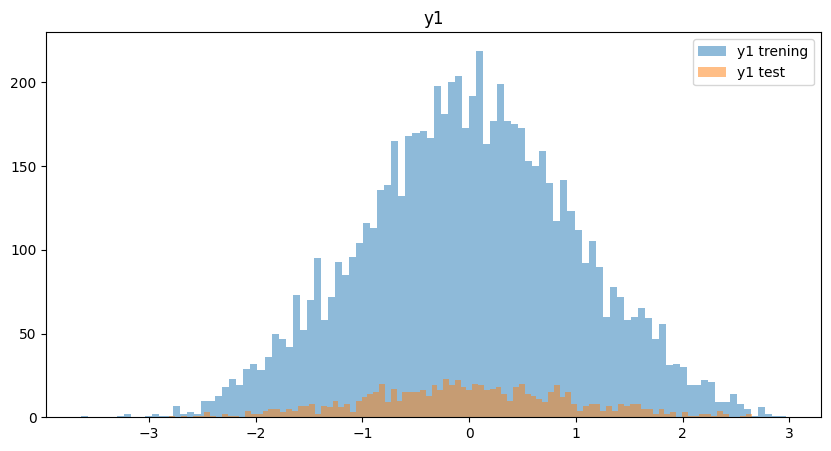

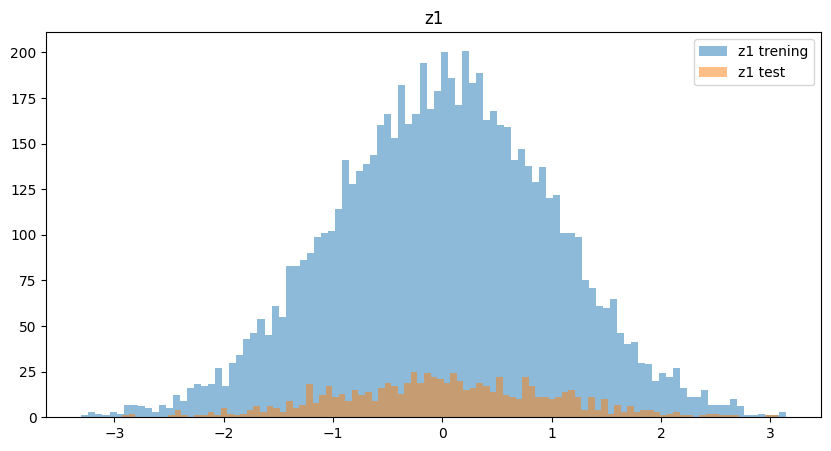

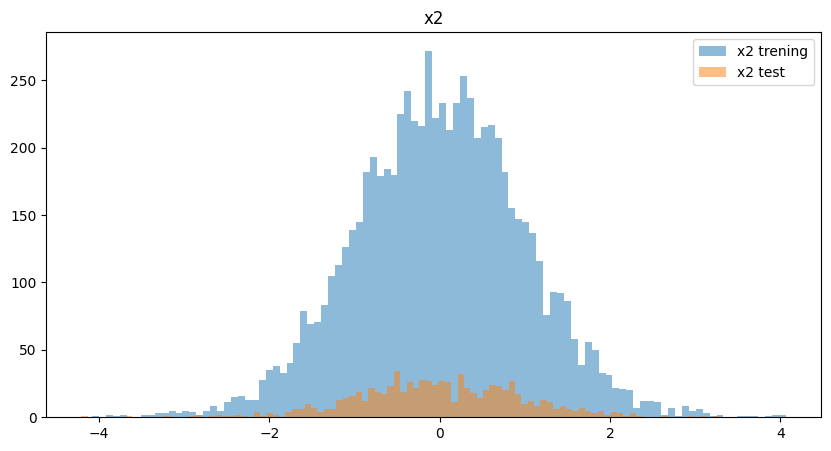

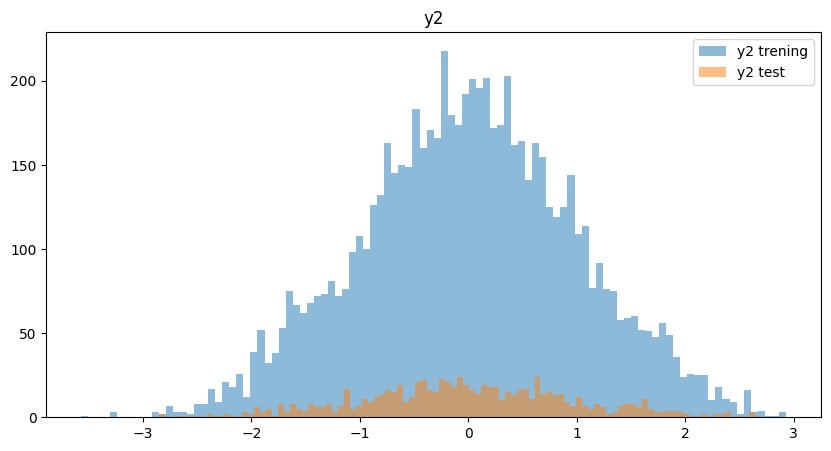

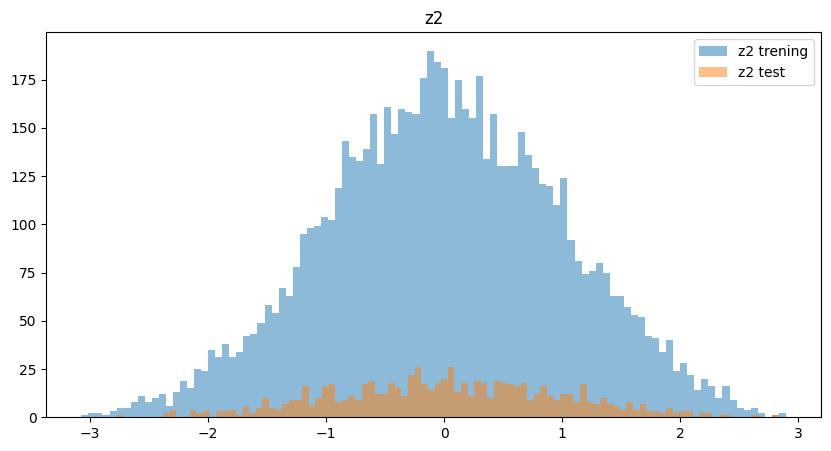

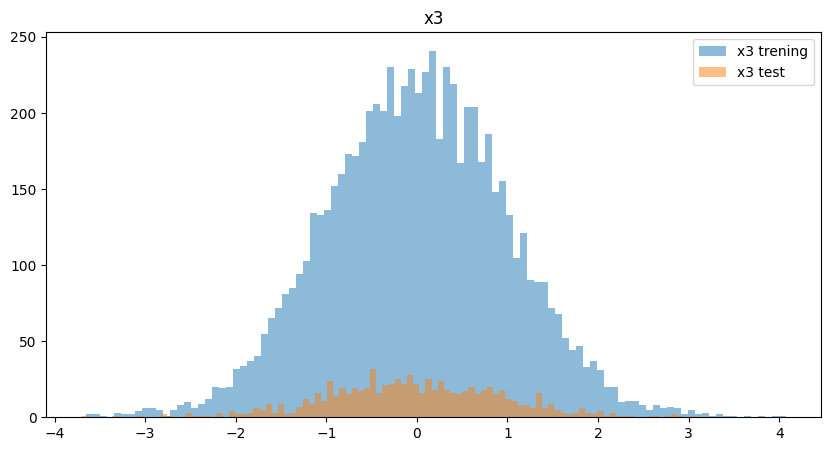

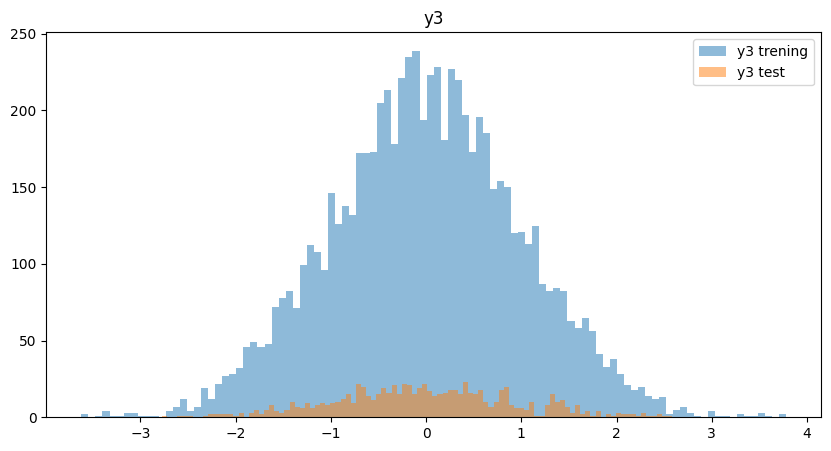

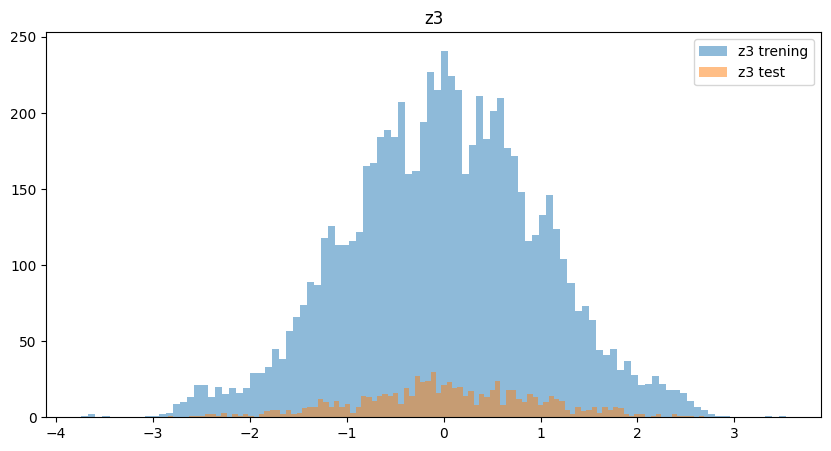

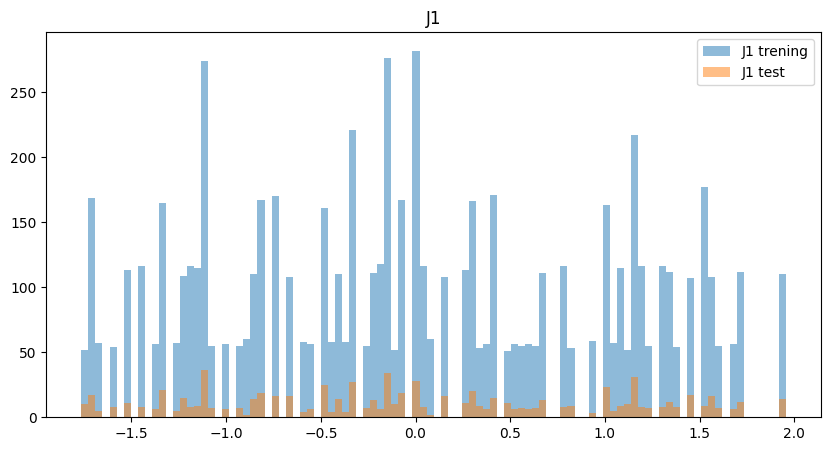

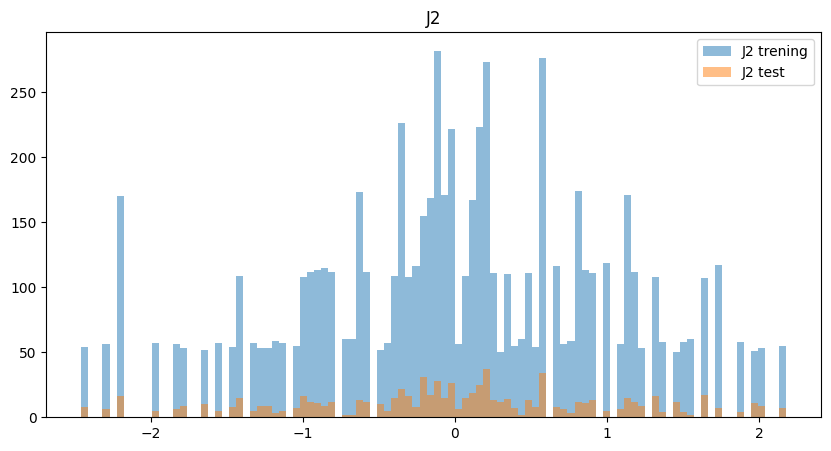

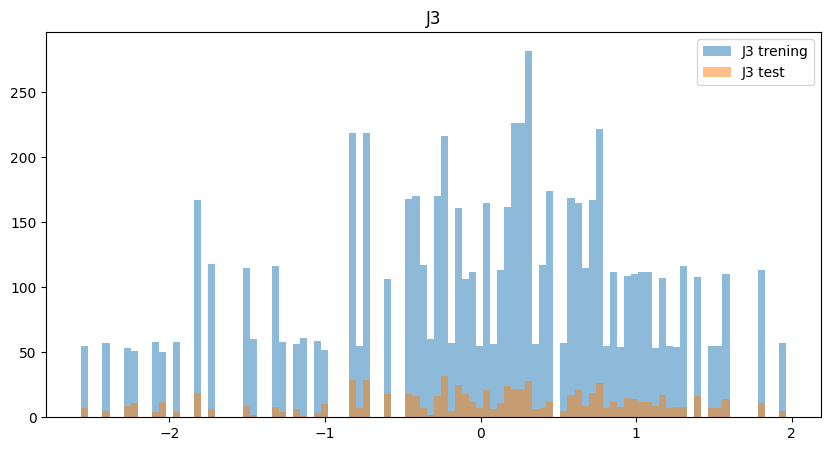

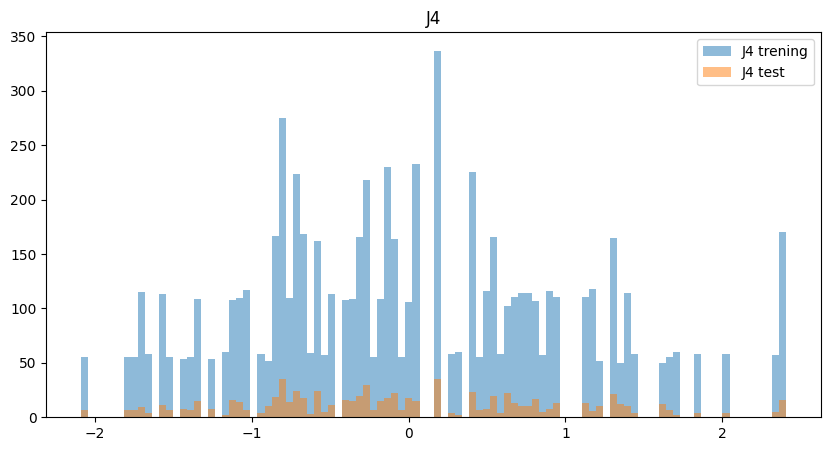

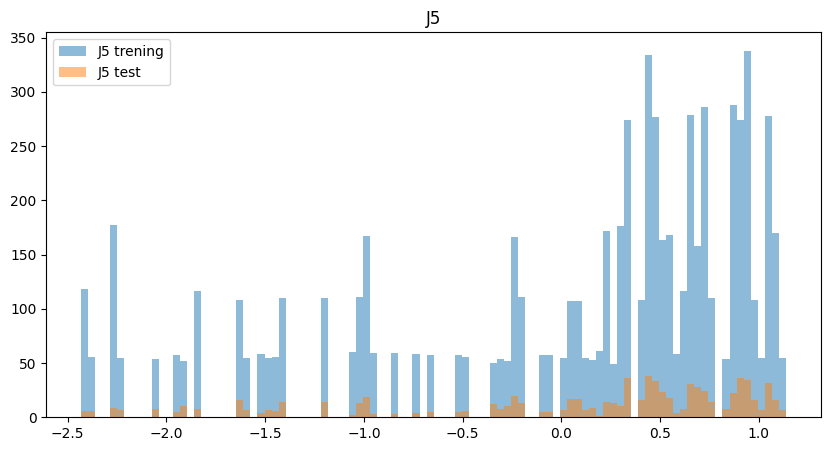

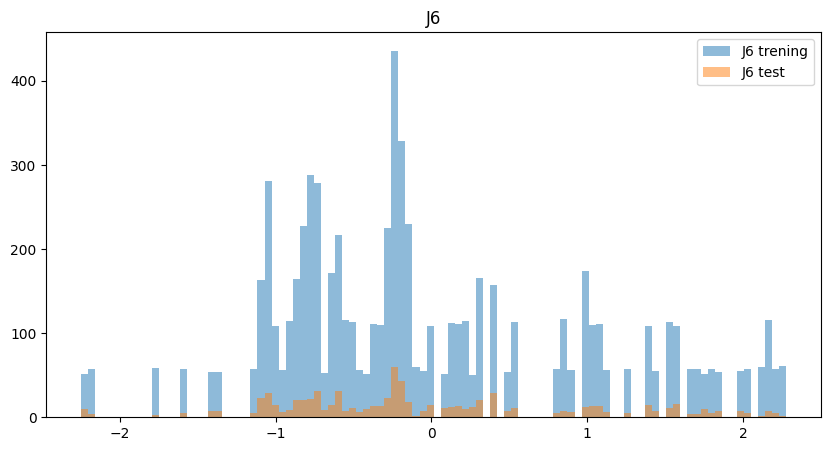

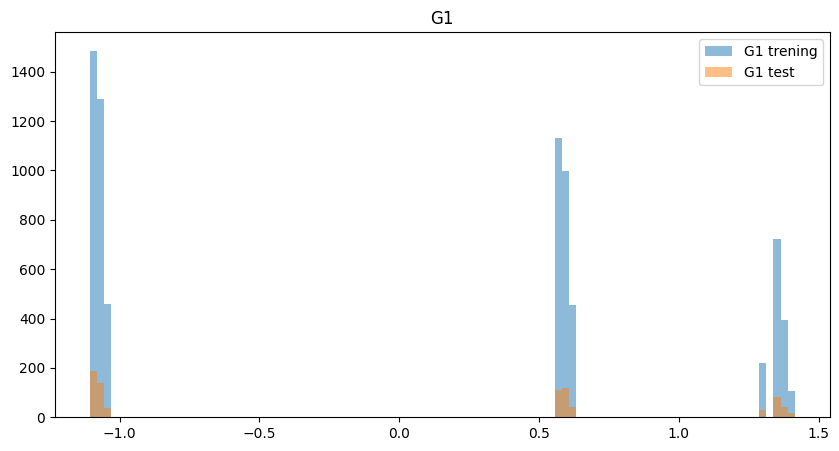

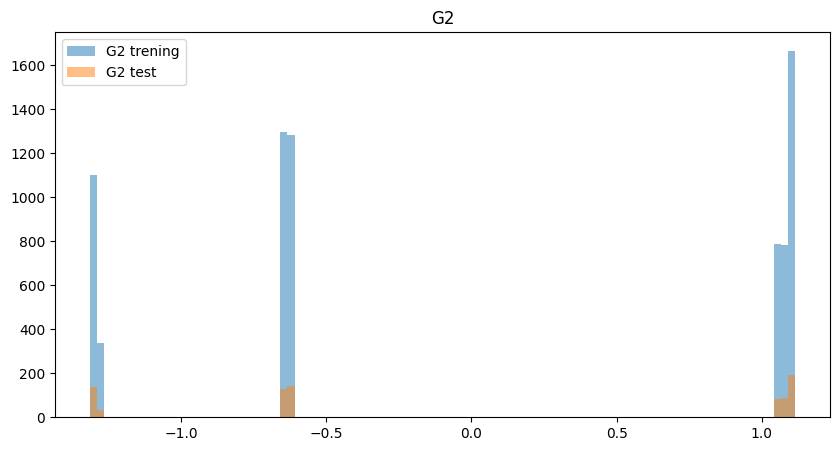

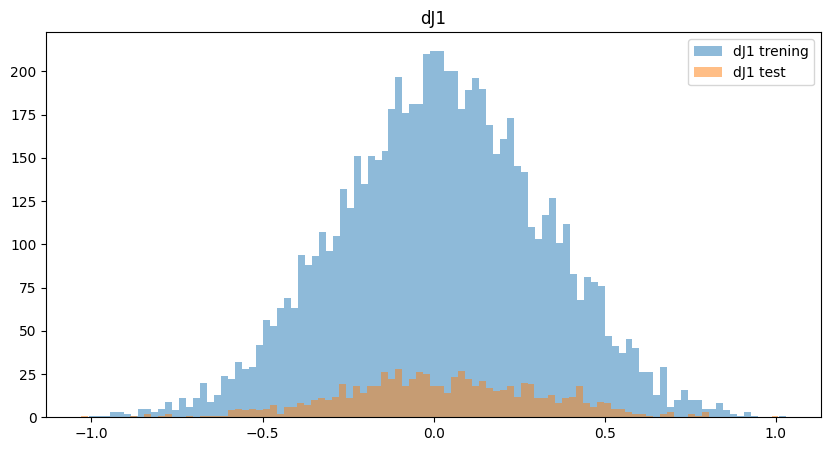

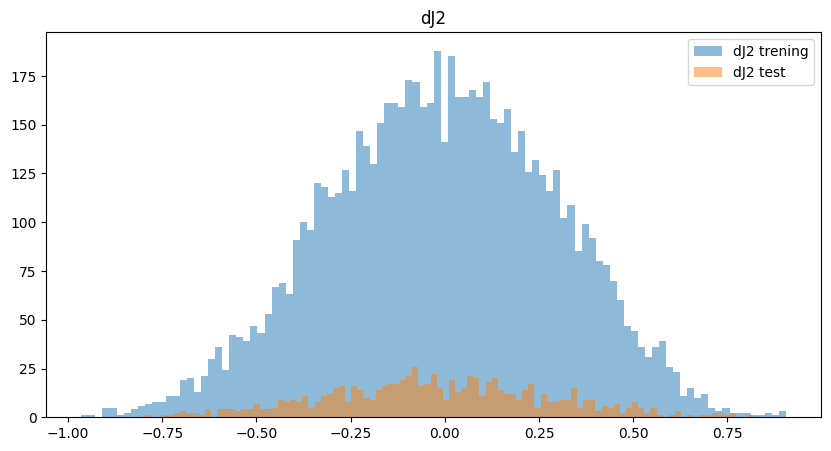

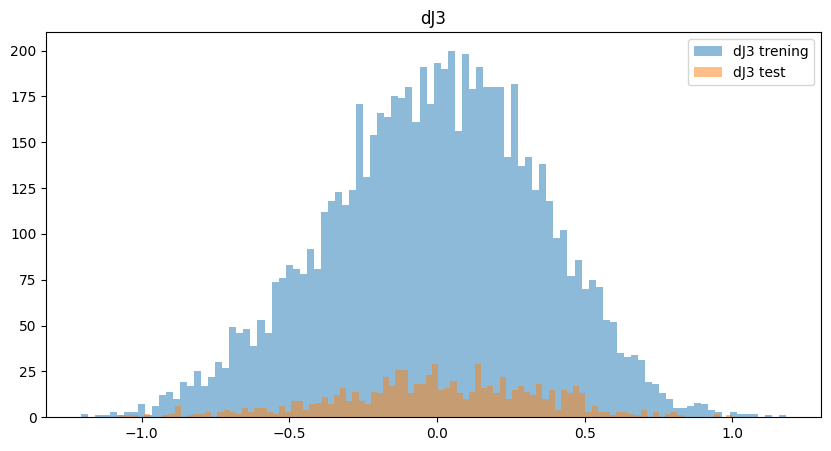

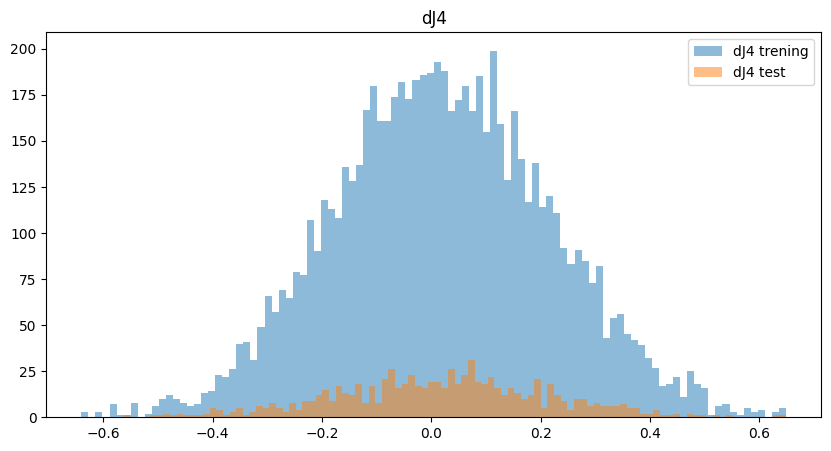

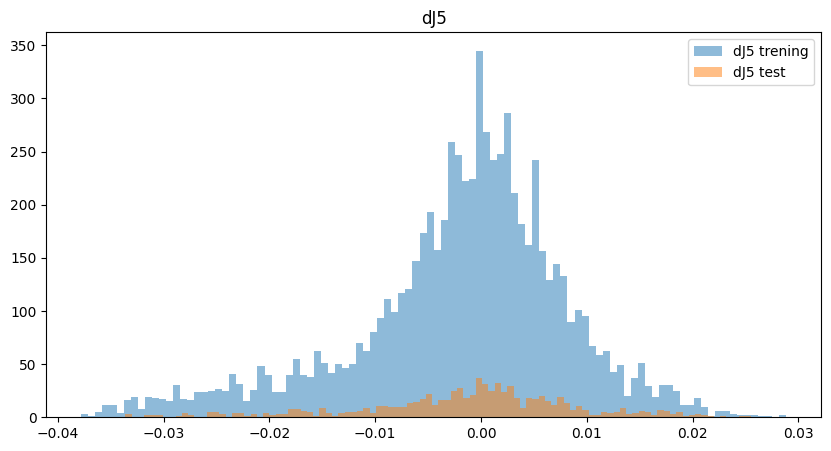

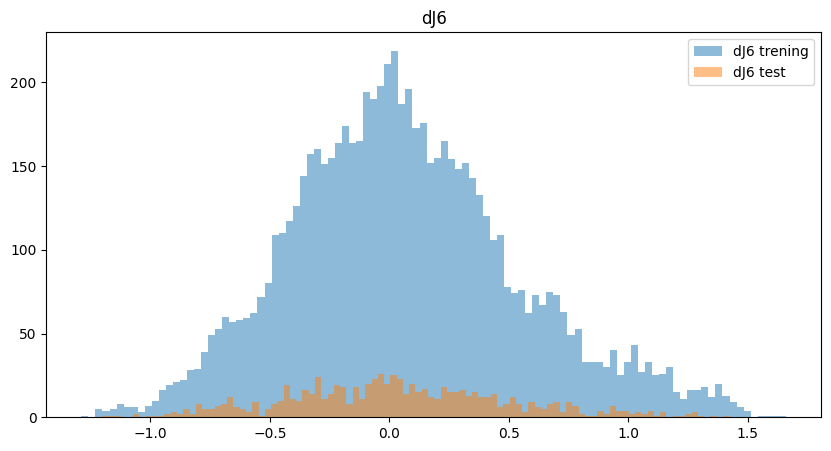

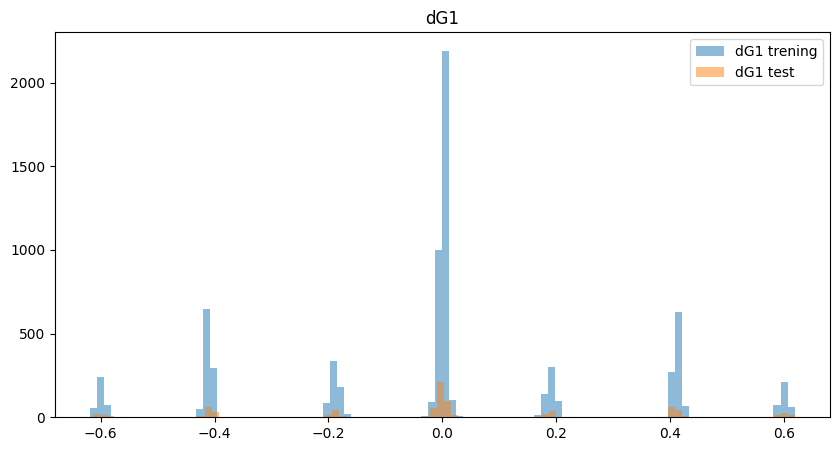

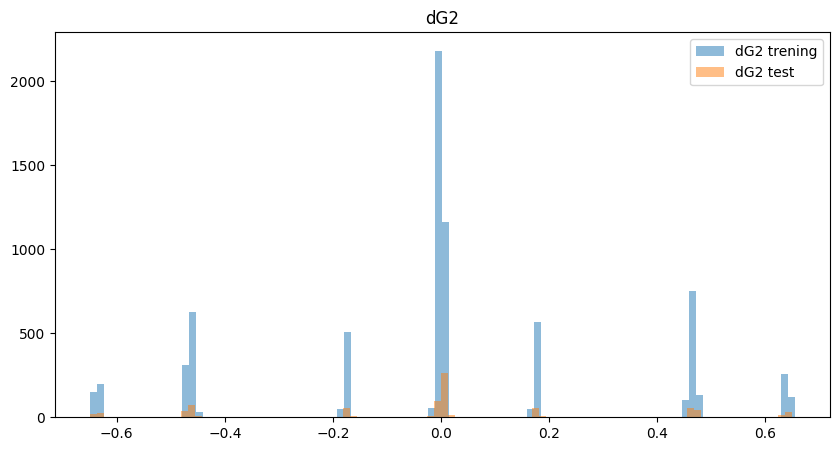

In [8]:
for i in range(x_train.shape[1]):
  plt.figure(figsize=(10, 5))
  plt.hist(x_train[:, i], bins=100, alpha=0.5, label=str(df.columns[i] + ' trening'))
  plt.hist(x_test[:, i], bins=100, alpha=0.5, label=str(df.columns[i] + ' test'))
  plt.title(df.columns[i])
  # plt.xlabel(df.columns[i])
  # plt.ylabel('Frequency')
  plt.legend()
  plt.show()

for i in range(y_train.shape[1]):
  plt.figure(figsize=(10, 5))
  plt.hist(y_train[:, i], bins=100, alpha=0.5, label=str(df.columns[i+x_train.shape[1]] + ' trening'))
  plt.hist(y_test[:, i], bins=100, alpha=0.5, label=str(df.columns[i+x_train.shape[1]] + ' test'))
  plt.title(df.columns[i+x_train.shape[1]])
  # plt.xlabel(df.columns[i+x_train.shape[1]])
  # plt.ylabel('Frequency')
  plt.legend()
  plt.show()

# Tworzenie i Konfiguracja Modelu

Podstawowe parametry modelu

In [10]:
OUTPUTS_PATH = Path("outputs/model_outputs")
MODEL_PATH = Path("outputs/model")

OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

input_shape = x_train.shape[-1]
num_labels = y_train.shape[-1]
print(input_shape, num_labels)

17 8


Lista callback do uczenia

In [11]:
callbacks_list = [
  tf.keras.callbacks.ModelCheckpoint(
    filepath=str(MODEL_PATH)+'/saved_model.keras',
    monitor='val_loss',
    save_best_only=True
  ),
  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=True
  ),
  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
  )]

## Wariant 1 - Budowanie modelu ręcznie

Parametry modelu

In [11]:
neurons = 320
dropout = 0.1

In [ ]:
"""
inputs = tf.keras.Input(shape=(input_shape,))

# augmentacja
#x = tf.keras.layers.GaussianNoise(0.1)(inputs)

x = tf.keras.layers.Dense(neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(dropout/2)(x)

# Pierwszy blok residual
x_skip = x
x = tf.keras.layers.Dense(neurons*2, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, x_skip])

# Drugi blok residual
x_skip = x
x = tf.keras.layers.Dense(neurons*2, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([x, x_skip])

outputs = tf.keras.layers.Dense(num_labels)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()
#""";

## Wariant 2 - Budowanie modelu za pomocą tunera

In [ ]:
"""
import keras_tuner as kt

input_shape = x_train.shape[-1]
num_labels = y_train.shape[-1]

def build_model(hp):
    
    num_blocks = hp.Int('num_blocks', min_value=4, max_value=8, step=1)
    neurons = hp.Int('neurons', min_value=64, max_value=640, step=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    
    inputs = tf.keras.Input(shape=(input_shape,))
    x = inputs
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    for i in range(num_blocks):
        x_skip = x
        x = tf.keras.layers.Dense(neurons*2, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, x_skip])
    
    outputs = tf.keras.layers.Dense(num_labels)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=16,
    executions_per_trial=1,
    #directory='ktuner_dir',
    project_name='diff_pred_tuning'
)

tuner.search(x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks_list)
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best number of blocks:", best_hp.get('num_blocks'))
print("Best neurons:", best_hp.get('neurons'))
print("Best learning rate:", best_hp.get('learning_rate'))
#""";

Trial 16 Complete [00h 06m 34s]
val_loss: 0.023840406909585

Best val_loss So Far: 0.013031317852437496
Total elapsed time: 02h 04m 31s
Best number of blocks: 8
Best neurons: 192
Best learning rate: 0.008437021601381293


Tworzenie modelu

In [ ]:
#model = build_model(best_hp)
#model.save(str(MODEL_PATH)+"/new_model_tuned.keras")

# Proces Uczenia

Odczytanie już utworzonego modelu

In [7]:
model = tf.keras.models.load_model("model_tuned.keras")

2025-06-17 12:09:03.904287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-17 12:09:04.188621: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ruszczka/projekty/test_files/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 142 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
"""
base_learning_rate = 1e-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=2318,
    decay_rate=0.8,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics = [tf.keras.metrics.RootMeanSquaredError()])
#""";

Proces uczenia

In [12]:
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=256,
    callbacks=callbacks_list
)

Epoch 1/300


I0000 00:00:1750154969.776492   11321 service.cc:145] XLA service 0x7f1860058b40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750154969.776598   11321 service.cc:153]   StreamExecutor device (0): Host, Default Version
2025-06-17 12:09:30.154458: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 3/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 45.8463 - root_mean_squared_error: 6.5524

I0000 00:00:1750154979.267247   11321 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 498ms/step - loss: 21.3600 - root_mean_squared_error: 4.4092 - val_loss: 491.9775 - val_root_mean_squared_error: 22.1806 - learning_rate: 0.0084
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.4565 - root_mean_squared_error: 0.6743 - val_loss: 22.4145 - val_root_mean_squared_error: 4.7344 - learning_rate: 0.0084
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ -0s -9266us/step - loss: 0.2237 - root_mean_squared_error: 0.4728 - val_loss: 2.5483 - val_root_mean_squared_error: 1.5963 - learning_rate: 0.0084
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271 - val_loss: 0.7973 - val_root_mean_squared_error: 0.8929 - learning_rate: 0.0084
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.1516 - root_mean_squared_error: 0.3893 - val_loss: 0.3618 - val_root_mean_squared_error: 0.6015 - learning_rate: 0.0084
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1288 - root_mean_squared_erro

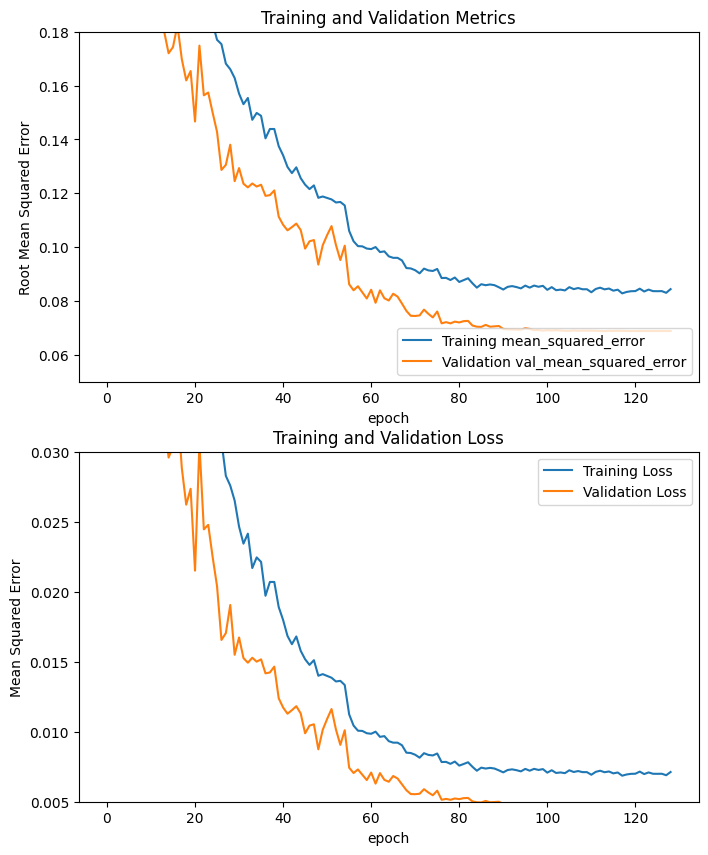

In [13]:
root_mean_squared_error = history.history['root_mean_squared_error']
val_root_mean_squared_error = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(root_mean_squared_error, label='Training mean_squared_error')
plt.plot(val_root_mean_squared_error, label='Validation val_mean_squared_error')
plt.legend(loc='lower right')
plt.ylabel('Root Mean Squared Error')
plt.ylim(0.05,0.18)
plt.title('Training and Validation Metrics')
plt.xlabel('epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.ylim(0.005,0.03)
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(str(OUTPUTS_PATH)+'/fig.png')

In [14]:
model.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732


[0.005184440407902002, 0.07200305908918381]

## Testowanie uzyskanego modelu

Zapisanie wyników predykcji

In [15]:
result = model.predict(x=x_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


Wyświetlenie błędów na poszczególnych przegubach

In [16]:
diff_test = np.rad2deg(np.mean(np.abs(result-y_test), axis=0))

joints_error_dict = dict(zip(df.columns[17:], diff_test))
for joint, error in joints_error_dict.items():
    print(f"{joint}: {error:.2f} stopni")

dJ1: 1.46 stopni
dJ2: 1.44 stopni
dJ3: 2.53 stopni
dJ4: 1.95 stopni
dJ5: 0.79 stopni
dJ6: 5.80 stopni
dG1: 3.24 stopni
dG2: 3.48 stopni


Wyświetlenie średniej i mediane błędu absolutnego

In [17]:
mean_test = np.rad2deg(np.mean(np.abs(result-y_test)))
median_test = np.rad2deg(np.median(np.abs(result-y_test)))

print(f"Średnia: {mean_test:.2f} stopni")
print(f"Mediana: {median_test:.2f} stopni")

Średnia: 2.59 stopni
Mediana: 1.56 stopni


## Zapisanie wyników do pliku .csv

In [18]:
cols = [ 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'G1', 'G2',
        'dJ1', 'dJ2', 'dJ3', 'dJ4', 'dJ5', 'dJ6', 'dG1', 'dG2',
        'pred_dJ1', 'pred_dJ2', 'pred_dJ3', 'pred_dJ4', 'pred_dJ5', 'pred_dJ6', 'pred_dG1', 'pred_dG2']

In [19]:
print(result.shape)
print(x_test[:,9:].shape)
print(y_test.shape)

(806, 8)
(806, 8)
(806, 8)


Zapisanie wyników do testowania na robocie

In [20]:
wyniki = pd.concat([pd.DataFrame(x_test[:,9:]*x_train_std[9:]+x_train_mean[9:], columns=cols[:8]),  # Pozycja początkowa
                    pd.DataFrame(y_test, columns=cols[8:16]),                                       # Różnica faktyczna
                    pd.DataFrame(result, columns=cols[16:])], axis=1)                               # Różnica przewidywana
wyniki.to_csv(str(OUTPUTS_PATH)+"/wyniki.csv", index=False, header=True)

In [21]:
wyniki.head(5)

,J1,J2,J3,J4,J5,J6,G1,G2,dJ1,dJ2,...,dG1,dG2,pred_dJ1,pred_dJ2,pred_dJ3,pred_dJ4,pred_dJ5,pred_dJ6,pred_dG1,pred_dG2
0,3.583625,1.903143,1.700541,1.080981,1.571561,3.299689,0.593138,0.894821,-0.308528,0.050791,...,0.000000,-0.005113,-0.279944,0.034990,-0.114977,0.084152,-0.026680,0.358314,0.163682,-0.205681
1,3.497668,2.404107,0.986582,1.296170,1.580765,2.942031,0.593138,0.894821,0.111768,0.486979,...,-0.184078,0.173851,0.100364,0.512693,-0.761861,0.252841,-0.007623,0.200293,-0.200839,0.189136
2,3.535240,1.907808,1.537685,1.243631,1.584743,2.776457,0.792556,0.720970,-0.392530,-0.120748,...,0.194304,-0.178964,-0.467364,-0.131439,-0.046255,0.179814,0.005646,-0.162043,0.198079,-0.165047
3,3.512490,2.242608,1.378738,1.069476,1.589393,2.637057,0.598252,0.894821,-0.071135,0.339465,...,0.005114,0.000000,-0.050933,0.319500,-0.258233,-0.033114,0.026736,-0.612557,-0.002509,-0.015430
4,3.095328,1.627730,1.905327,1.163912,1.592701,2.333760,0.787442,0.726083,-0.327777,0.396761,...,0.184077,-0.178964,-0.333470,0.407988,-0.029933,-0.391173,0.007152,-0.373165,0.095999,-0.073524


In [39]:
np.sum(np.abs(np.rad2deg(wyniki["dJ1"])-np.rad2deg(wyniki["pred_dJ1"]))<1)

np.int64(368)

Histogram otrzymanych wyników

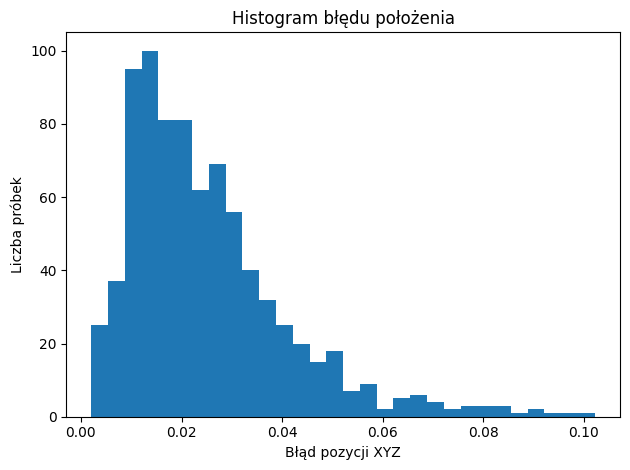

In [24]:
RESULT_PATH = Path("/mnt/c/Users/rados/downloads")

# Załdowanie danych i obliczenie błędów
df_wyniki = pd.read_csv(str(RESULT_PATH)+'/wyniki_vert_converted.csv')
df_wyniki['error_x'] = df_wyniki['x_to_predicted'] - df_wyniki['x_to_ground_truth']
df_wyniki['error_y'] = df_wyniki['y_to_predicted'] - df_wyniki['y_to_ground_truth']
df_wyniki['error_z'] = df_wyniki['z_to_predicted'] - df_wyniki['z_to_ground_truth']
df_wyniki['error_magnitude'] = np.sqrt(df_wyniki[['error_x', 'error_y', 'error_z']].pow(2).sum(axis=1))

# Wyświetlenie histogramu błędu położenia
plt.figure()
plt.hist(df_wyniki['error_magnitude'], bins=30)
plt.title('Histogram błędu położenia')
plt.xlabel('Błąd pozycji XYZ')
plt.ylabel('Liczba próbek')
plt.tight_layout()
plt.show()
